In [36]:
from __future__ import print_function
from __future__ import division
import os
import pickle
import json
import subprocess
from IPython.display import display
from IPython.display import Audio
import bisect
from collections import namedtuple
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import scipy.io.wavfile
from python_speech_features import mfcc
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import bisect

%run ../antonissameer/dba.py
%run ../antonissameer/utils.py

from matplotlib.ticker import MultipleLocator, \
     FormatStrFormatter, AutoMinorLocator
%matplotlib inline

In [2]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [3]:
with open("config.json") as json_data_file:
    config = json.load(json_data_file)

In [4]:
Align = namedtuple('Align', ['word', 'start', 'end'])
Instance = namedtuple('Instance', ['uttr', 'start', 'end'])

In [5]:
segment_map = pickle.load(open(config['es']['segment_dict_fname'], "rb"))
align_dict = pickle.load(open(config['es']['align_dict_fname'], "rb"), encoding='utf-8')

### Find words spoken across speakers, and within speakers

Find words longer than *threshold* ms in duration

In [6]:
dur_thresh = 40 # 400 ms
word_type = "es_cnt"

def get_word_details(dur_thresh, word_type):
    word_list = [(a.word, fid, sid, i) for fid in align_dict 
                for sid in align_dict[fid] 
                for i, a in enumerate(align_dict[fid][sid][word_type]) 
                if (a.end-a.start) > dur_thresh]

    word_details = {}
    for w, f, s, i in word_list:
        if w not in word_details:
            word_details[w] = {"calls":[f], "uttrs":[s], "ixs":[i]}
        else:
            word_details[w]["calls"].append(f)
            word_details[w]["uttrs"].append(s)
            word_details[w]["ixs"].append(i)
    
    for w in word_details:
        word_details[w]["word_count"] = len(word_details[w]["ixs"])
        word_details[w]["call_count"] = len(set(word_details[w]["calls"]))
        word_details[w]["uttr_count"] = len(set(word_details[w]["uttrs"]))
        
    print("duration filter: {0:d} ms".format(dur_thresh*10))
    print("{0:10s} --- {1:5d}".format("total words", len(word_details)))
    
    return word_details

In [7]:
def print_index_details(word_details, w, i):
    align_ix = word_details[w]["ixs"][i]
    call_id = word_details[w]["calls"][i]
    seg_id = word_details[w]["uttrs"][i]
    loc = "{0:d} - {1:d} ms".format(align_dict[call_id][seg_id][word_type][align_ix].start, 
                    align_dict[call_id][seg_id][word_type][align_ix].end) 
    print("""details for: {0:10s} 
             in uttr: {1:7s} 
             at time: {2:10s}""".format(w, word_details[w]["uttrs"][i], loc))

In [8]:
def print_word_details(word_details, w):
    print("details for: {0:10s}".format(w))
    print("{0:10s} | {1:5d}".format("word count", word_details[w]["word_count"]))
    print("{0:10s} | {1:5d}".format("call count", word_details[w]["call_count"]))
    print("{0:10s} | {1:5d}".format("uttr count", word_details[w]["uttr_count"]))

In [9]:
word_details = get_word_details(dur_thresh, word_type)

duration filter: 400 ms
total words ---  8224


In [10]:
# display the most common words
most_common = sorted([(w, word_details[w]["word_count"]) for w in word_details], 
                           reverse=True, key=lambda t:t[1])[:5]
print("{0:20s} --- {1:10s}".format("word", "count"))
print("".join(["{0:20s} --- {1:5d}\n".format(w, f) for w, f in most_common]))

word                 --- count     
MMM                  ---   504
<LAUGH>              ---   499
ENTONCES             ---   450
CLARO                ---   363
AH                   ---   298



In [11]:
most_common_by_calls = sorted(
    [(w, word_details[w]["word_count"], word_details[w]["call_count"]) 
     for w in word_details], reverse=True, key=lambda t:t[2])
print("{0:10s} | {1:5} | {2:5} ".format("word", "count", "calls"))
print("".join(["{0:10s} | {1:5d} | {2:5d} \n".format(w,c,f) 
              for w, c, f in most_common_by_calls[:10]]))

word       | count | calls 
ENTONCES   |   450 |    91 
MMM        |   504 |    88 
<LAUGH>    |   499 |    79 
AH         |   298 |    79 
BUENO      |   291 |    78 
BIEN       |   247 |    77 
CLARO      |   363 |    71 
TELéFONO   |    94 |    55 
EH         |   163 |    54 
DESPUéS    |    70 |    50 



In [12]:
es_word = 'TELéFONO'
uttr_wavs_path_string = "../uttr_fa_vad_wavs/uttr_wavs/{0:s}.wav"

In [13]:
print_word_details(word_details, es_word)

details for: TELéFONO  
word count |    94
call count |    55
uttr count |    88


In [14]:
def get_align_tuple(word_details, w, ix):
    return (word_details[w]["calls"][ix], 
               word_details[w]["uttrs"][ix],
               word_details[w]["ixs"][ix])

In [15]:
def get_segment_wav(sid, start_10ms, end_10ms):
    sr1, y1 = scipy.io.wavfile.read(uttr_wavs_path_string.format(sid))
    start = start_10ms * int(sr1 / 100)
    end = end_10ms * int(sr1 / 100)
    return sr1, y1[start:end]

In [16]:
def _get_segment_mfcc(sid, start_10ms, end_10ms):
    sr1, y1 = get_segment_wav(sid, start_10ms, end_10ms)
    mfcc_segment = mfcc(y1, sr1)
    mfcc_segment = (mfcc_segment - np.mean(mfcc_segment)) / np.std(mfcc_segment)
    return mfcc_segment

In [17]:
def get_start_end_10ms(f,s,ind):
    return align_dict[f][s]["es_cnt"][ind].start, align_dict[f][s]["es_cnt"][ind].end

In [18]:
def compute_dtw(w_1, w_2):
    f1, s1, ind1 = w_1
    start_i, end_i = get_start_end_10ms(f1, s1, ind1)
    i_mfcc = _get_segment_mfcc(s1, start_i, end_i)
    
    f2, s2, ind2 = w_2
    start_j, end_j = get_start_end_10ms(f2, s2, ind2)
    j_mfcc = _get_segment_mfcc(s2, start_j, end_j)
    
    # compute dtw
    pair_cost, _ = dtw(i_mfcc, j_mfcc, doNorm=True)
    return pair_cost

In [19]:
def compute_pairwise_dtw(loc_tuples):
    d = len(loc_tuples)
    cost = np.zeros((d, d))
    
    with tqdm(total=d*d) as pbar:
        for i in range(d):
#             f1, s1, ind1 = loc_tuples[i]
#             start_i, end_i = get_start_end_10ms(f1, s1, ind1)
#             i_mfcc = _get_segment_mfcc(s1, start_i, end_i)
            cost[i,i] = 1
            pbar.update(1)
            for j in range(i+1, d):
                it = i * d + (j + 1)
#                 f2, s2, ind2 = loc_tuples[j]
#                 start_j, end_j = get_start_end_10ms(f2, s2, ind2)
#                 j_mfcc = _get_segment_mfcc(s2, start_j, end_j)
                # compute dtw
#                 pair_cost, _ = dtw(i_mfcc, j_mfcc, doNorm=True)
                pair_cost = compute_dtw(loc_tuples[i], loc_tuples[j])
                cost[i,j] = pair_cost
                cost[j,i] = 1.0
                pbar.set_description("it: {0:d}".format(it))
                pbar.update(2)
    return cost
    

In [20]:
def get_calls_for_word(words_details, word):
    word_segments = {}
    for w, f, s, i in words_details:
        if w == word:
            if f not in word_segments:
                word_segments[f] = 1
            else:
                word_segments[f] += 1
    print("done")
    return word_segments

In [21]:
def get_segment_mfcc(words_details, w, ix):
    call, uttr, index = get_align_tuple(words_details, w, ix)
    start_i, end_i = get_start_end_10ms(call, uttr, index)
    return _get_segment_mfcc(uttr, start_i, end_i)

In [22]:
def play_uttr_seg(uttr, start_i, end_i):
    sr, y = get_segment_wav(uttr, start_i, end_i)
    display(Audio(y, rate=sr))

In [94]:
def play_align_seg(words_details, w, ix):
    call = words_details[w]["calls"][ix]
    uttr = words_details[w]["uttrs"][ix]
    index = words_details[w]["ixs"][ix]
    start_i, end_i = get_start_end_10ms(call, uttr, index)
    time_str = "{0:d} - {1:d} ms".format(start_i, end_i) 
    print("{0:10s} | {1:7s} | {2:8s}".format(es_word, 
                                             word_details[es_word]["uttrs"][ix],
                                             time_str))
    play_uttr_seg(uttr, start_i, end_i)

In [95]:
def get_dba_for_word_samples(word_details, w, ixs):
    word_mfccs = []
    for ix in ixs:
        word_mfccs.append(get_segment_mfcc(word_details, w, ix))
    word_dba = dba(s=word_mfccs)
    return word_dba

In [118]:
def print_align(uttr, key='es'):
    words = " ".join([w.word for w in align_dict[i.uttr.split('.')[0]][i.uttr][key]])
    print("{0:>15s} | {1:>40s}".format(key + " words", words))

In [137]:
def find_align_words_for_node(uttr, start, end, key='es'):
    align_words_list = align_dict[i.uttr.split('.')[0]][i.uttr][key]
    words, start_times, end_times = zip(*(align_words_list))
    start_i = bisect.bisect(end_times, start)
    # end index will be 1 beyond the actual end
    end_i = bisect.bisect(start_times, end) 
    print("{0:>15s} | {1:s}, DUR: {2:d} ms".format(key + " alignment", 
                                                  " ".join(words[start_i:end_i]),
                                                 (end_times[end_i-1]-start_times[start_i])*10))
    return words[start_i:end_i]

In [109]:
# Play few audio segments:
for i in range(3):
    play_align_seg(word_details, es_word, i)

TELéFONO   | 054.076 | 54 - 112 ms


TELéFONO   | 116.046 | 548 - 601 ms


TELéFONO   | 116.002 | 585 - 639 ms


In [98]:
word_tuples = [(word_details[es_word]["calls"][i], 
                word_details[es_word]["uttrs"][i], 
                word_details[es_word]["ixs"][i]) 
               for i in range(word_details[es_word]["word_count"])]

In [99]:
cost = compute_pairwise_dtw(word_tuples[:10])

it: 90: 100%|██████████| 100/100 [00:00<00:00, 202.55it/s]


### Get top 10 matches

argpartition reorders indices by moving smaller elements in front of the *10th* largest value, and larger elements after it

In [100]:
def print_top_k_matches(arr2D, word_details, es_word, k=5, reverse=False):
    if reverse:
        arr2D[np.tril_indices(arr2D.shape[0])] = 0
        ind = np.unravel_index(np.argpartition(arr2D, -k, axis=None)[-k:], arr2D.shape)
    else:
        arr2D[np.tril_indices(arr2D.shape[0])] = 1
        ind = np.unravel_index(np.argpartition(arr2D, k, axis=None)[:k], arr2D.shape)
    for i, (x,y) in enumerate(zip(ind[0], ind[1])):
        #print(x,y)
        x_t = get_align_tuple(word_details, es_word, x)
        y_t = get_align_tuple(word_details, es_word, y)
        print("--------------------\n Pair - {0:2d}".format(i))
        play_align_seg(word_details, es_word, x)
        play_align_seg(word_details, es_word, y)
        print("{0:<25s} | {1:10.3f}".format("dtw for seg 1 vs seg2", 1-cost[x,y]))
        #print("--------------------\n computing dba")
        mfcc_x = get_segment_mfcc(word_details, es_word, x)
        mfcc_y = get_segment_mfcc(word_details, es_word, y)
        dba_repr = dba([get_segment_mfcc(word_details, es_word, x),
                       get_segment_mfcc(word_details, es_word, y)])
        # compute dtw
        pair_cost_x, _ = dtw(mfcc_x, dba_repr, doNorm=True)
        pair_cost_y, _ = dtw(mfcc_y, dba_repr, doNorm=True)
        print("{0:<25s} | {1:10.3f}".format("dtw for seg 1 vs DBA", 1-pair_cost_x))
        print("{0:<25s} | {1:10.3f}".format("dtw for seg 2 vs DBA", 1-pair_cost_y))
        #print("{0:<25s} | {1:10.3f}".format("dtw for seg 1 vs 2", dtw(mfcc_x, mfcc_y, doNorm=True)[0]))
        
        '''
        print(compute_dtw(get_align_tuple(word_details, es_word, x), 
                          get_align_tuple(word_details, es_word, y)))
        '''
    return ind
    

In [112]:
print("Best matches")
ind = print_top_k_matches(cost, word_details, es_word, 1, reverse=False)
print("\n\n--------------------")
print("Worst matches")
ind = print_top_k_matches(cost, word_details, es_word, 1, reverse=True)

Best matches
--------------------
 Pair -  0
TELéFONO   | 093.216 | 150 - 221 ms


TELéFONO   | 093.227 | 182 - 224 ms


dtw for seg 1 vs seg2     |      0.852
dtw for seg 1 vs DBA      |      0.857
dtw for seg 2 vs DBA      |      0.994


--------------------
Worst matches
--------------------
 Pair -  0
TELéFONO   | 054.076 | 54 - 112 ms


TELéFONO   | 027.043 | 224 - 270 ms


dtw for seg 1 vs seg2     |      0.666
dtw for seg 1 vs DBA      |      0.698
dtw for seg 2 vs DBA      |      0.994


[[ 0.     0.218  0.27   0.334  0.25   0.268  0.234  0.255  0.248  0.322]
 [ 0.     0.     0.228  0.202  0.267  0.21   0.207  0.255  0.233  0.247]
 [ 0.     0.     0.     0.299  0.304  0.277  0.293  0.278  0.257  0.229]
 [ 0.     0.     0.     0.     0.261  0.202  0.254  0.29   0.267  0.247]
 [ 0.     0.     0.     0.     0.     0.148  0.173  0.249  0.326  0.25 ]
 [ 0.     0.     0.     0.     0.     0.     0.164  0.274  0.292  0.198]
 [ 0.     0.     0.     0.     0.     0.     0.     0.231  0.205  0.265]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.217  0.243]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.265]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]]


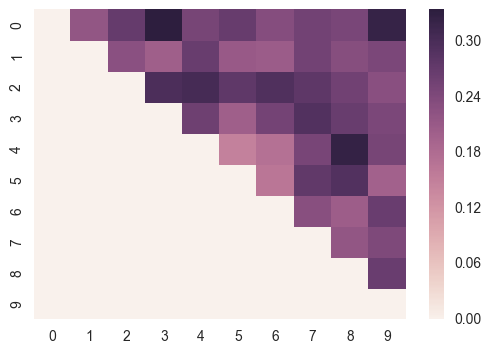

In [30]:
# plt.imshow(cost, cmap="summer", interpolation='nearest')
# sns.heatmap(cost, annot=True, fmt=".1f")
sns.heatmap(cost)
print(cost)

### Use prototypes for sub-proto-clustering

In [69]:
!head -n 10 "../antonissameer/week2/prototypes-oracle-bin/details.txt"
!wc "../antonissameer/week2/prototypes-subtrain-goldVAD-bin/details.txt"

LINGUISTICS 089.177 535 563
LINGUISTICS 089.177 563 625
JOHNNY 070.147 182 200
EXPLAIN 048.072 701 764
EXPLAIN 066.042 190 246
EXPLAIN 078.133 583 640
EXPLAIN 082.070 660 709
EXPLAIN 083.200 648 703
EXPLAIN 089.007 13 35
EXPLAIN 089.007 131 247
  117608  470432 2367875 ../antonissameer/week2/prototypes-subtrain-goldVAD-bin/details.txt


In [55]:
proto_details = {}
instances = 0
with open(config['proto']['instance_details'], "r") as f:
    for line in f:
        line_items = line.strip().split()
        proto_name = line_items[0]
        if proto_name not in proto_details:
            proto_details[proto_name] = []
        instance = Instance(line_items[1], int(line_items[2]), int(line_items[3]))
        proto_details[proto_name].append(instance)
        instances += 1
print(instances)

117608


In [73]:
en_stop_words = set(nltk.corpus.stopwords.words("english"))
proto_sorted_by_instances = [k for k, v in sorted(proto_details.items(), 
                                                  reverse=True, key=lambda t: len(t[1]))
                             if k.lower() not in en_stop_words]
# proto_details[es_word]
k_start = 75
k_end = k_start + 10
print("{0:>20s} | {1:>10s}".format("proto","# instances"))
print("\n".join("{0:>20s} | {1:>10d}".format(k, len(proto_details[k])) 
                for k in proto_sorted_by_instances[k_start: k_end]))
# en_stop_words

               proto | # instances
                SAYS |        118
                TALK |        118
               SINCE |        114
               MONEY |        111
                 DAD |        111
             HUNDRED |        111
                EVEN |        108
               HELLO |        106
             ANOTHER |        105
                 GOT |        105


In [74]:
proto_details['HUNDRED'][:5]

[Instance(uttr='058.140', start=24, end=56),
 Instance(uttr='058.140', start=114, end=144),
 Instance(uttr='048.145', start=78, end=113),
 Instance(uttr='048.145', start=156, end=188),
 Instance(uttr='063.046', start=806, end=840)]

In [138]:
for i in proto_details['HUNDRED'][:5]:
    uttr_string = "uttr = {0:s}, duration (ms) = {1:d}".format(i.uttr, (i.end-i.start)*10)
    print("{0:^50s}".format(uttr_string))
    _ = find_align_words_for_node(*i)
    print_align(i.uttr, "es")
    print_align(i.uttr, "en")
    play_uttr_seg(*i)


       uttr = 058.140, duration (ms) = 320        
   es alignment | PICO DE PESOS, DUR: 700 ms
       es words | CIENTO Y PICO DE PESOS CIENTO SESENTA Y PICO CREO
       en words | HUNDRED SOMETHING DOLLARS ONE HUNDRED SIXTY SIXTY SOMETHING THINK


       uttr = 058.140, duration (ms) = 300        
   es alignment | CIENTO SESENTA, DUR: 920 ms
       es words | CIENTO Y PICO DE PESOS CIENTO SESENTA Y PICO CREO
       en words | HUNDRED SOMETHING DOLLARS ONE HUNDRED SIXTY SIXTY SOMETHING THINK


       uttr = 048.145, duration (ms) = 350        
   es alignment | SEISCIENTAS PESETAS, DUR: 870 ms
       es words | SON SEISCIENTAS PESETAS SETECIENTAS Y PUEDES COMER LO QUE QUIERAS
       en words | ARE SIX HUNDRED PESETAS SEVEN HUNDRED AND CAN EAT WHATEVER WHATEVER WANT


       uttr = 048.145, duration (ms) = 320        
   es alignment | SETECIENTAS, DUR: 760 ms
       es words | SON SEISCIENTAS PESETAS SETECIENTAS Y PUEDES COMER LO QUE QUIERAS
       en words | ARE SIX HUNDRED PESETAS SEVEN HUNDRED AND CAN EAT WHATEVER WHATEVER WANT


       uttr = 063.046, duration (ms) = 340        
   es alignment | DóLARES, DUR: 440 ms
       es words | TIENES QUE TENER UN LOCAL DE ACUERDO A SUS EH SUS ESPECIFICACIONES O QUé ES LO QUE TIENE QUE TENER EL LOCAL TIENES QUE ABRIR UNA LETRA DE CRéDITO POR QUINIENTOS MIL DóLARES ABIERTA
       en words | YOU NEED HAVE A PLACE ACCORDING TO THEIR EH THEIR SPECIFICATIONS OR WHAT THE PLACE NEEDS TO HAVE HAVE TO OPEN A LINE OF CREDIT FOR FIVE HUNDRED THOUSAND DOLLARS OPEN
